# Laboratory 3 - Exercises

### Requirements and helpers

In [5]:
%pip install qiskit==1.2.4 qiskit-ibm-runtime qiskit_aer qiskit-dynamics
%pip install matplotlib pylatexenc seaborn

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, DensityMatrix, Statevector
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit.circuit import Parameter  
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector
import qiskit.pulse as pulse
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython import display

def plot_bloch_traj(states,mod=1):
    from qiskit.visualization.bloch import Bloch
    from qiskit.quantum_info import Operator
    import numpy as np
    import matplotlib.pyplot as plt
    X = Operator.from_label('X'); 
    Y = Operator.from_label('Y'); 
    Z = Operator.from_label('Z'); 

    _bloch = Bloch()
    _bloch.point_marker = ['o']
    _bloch.point_color = ['b']; 

    for i in range(len(states)):
        if np.mod(i,mod) != 0:
            continue;
        _bloch.add_points([states[i].expectation_value(X).real, states[i].expectation_value(Y).real, states[i].expectation_value(Z).real])
    
    _bloch.render(); 

def plot_qubit_dynamics(sol, t_eval):
    from qiskit.quantum_info import Operator
    
    X = Operator.from_label('X');
    Y = Operator.from_label('Y');
    Z = Operator.from_label('Z');

    n_times = len(sol.y)
    x_data = np.zeros((n_times,))
    y_data = np.zeros((n_times,))
    z_data = np.zeros((n_times,))

    for t_i, sol_t in enumerate(sol.y):
        x_data[t_i] = sol_t.expectation_value(X).real
        y_data[t_i] = sol_t.expectation_value(Y).real
        z_data[t_i] = sol_t.expectation_value(Z).real

    _, ax = plt.subplots(figsize = (20, 6))
    fontsize = 16;
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(t_eval/1e-9, x_data, label = '$\\langle X \\rangle$')
    plt.plot(t_eval/1e-9, y_data, label = '$\\langle Y \\rangle$')
    plt.plot(t_eval/1e-9, z_data, label = '$\\langle Z \\rangle$')
    plt.legend(fontsize = fontsize)
    ax.set_xlabel('$t$ [ns]', fontsize = fontsize)
    ax.set_title('Bloch vector vs. $t$', fontsize = fontsize)
    plt.show()

def fit_function(x_values, y_values, function, init_params):
    from scipy.optimize import curve_fit
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

def plot_populations(sol,tend):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
    plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, tend])
    plt.vlines(tend, 0, 1.05, "k", linestyle="dashed")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Exercise 1

Consider a two-level system with natural frequency $\omega = 2\pi\cdot\text{4.95623 GHz}$ coupled to a 5 GHz drive with driving strength $\Omega = 2\pi\cdot\text{100 MHz}$ (AWG sampling frequency 4.5 GHz). The system is characterized by energy relaxation and dephasing with $\Gamma_1 = \text{16 kHz}$, $\Gamma_2 = \text{8 kHz}$. 

a. Build a `DynamicsBackend` to simulate the considered system. <br>
b. Fine-tune the drive frequency using a coarse-fine (frequency sweep-Ramsay experiment) procedure. <br>
c. Calibrate Rabi pulses ensuring that at least 10 pulses can be operated within $min(T_1,T_2)/100$. <br>
d. Build the pulse schedule to operate $\hat{O} = \hat{X}\hat{T}\hat{H}$, recalling $\hat{H}=\hat{X}\hat{Y}^{1/2}$ and $\hat{T} = \hat{R}_z(\pi/4)$.  <br>
e. Apply the pulse schedule to the initial state $|0\rangle$, characterize the state by quantum tomography, and verify with an equivalent `QuantumCircuit`.<br>

_Hints_: use `num_points = 10`, `delay_dt = 40000` for Hahn echo experiments.

In [8]:
# a.
omega = 2*np.pi*4.95623e9
omega_d = 2*np.pi*5e9
Omega = 2*np.pi*100e6
dt = 1/(4.5e9)
gamma1 = 16e3
gamma2 = 8e3

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')
I = Operator.from_label('I')

hdrift = 1/2 * omega * Z
hdrive = Omega * X
diss1   = np.sqrt(gamma1) * 0.5 * (X + 1j * Y);
diss2   = np.sqrt(gamma2) * Z; 

solver = Solver(static_hamiltonian=hdrift, hamiltonian_operators=[hdrive], hamiltonian_channels=["d0"], rotating_frame=hdrift, channel_carrier_freqs={"d0":omega_d/2/np.pi}, dt=dt, static_dissipators=[diss1,diss2])
backend = DynamicsBackend(solver=solver,solver_options={'max_step':200*dt});

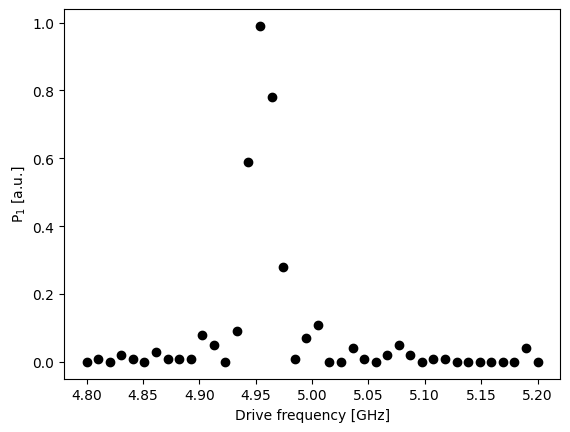

In [11]:
# b.1 Corase tuning
#########################################
# Experiment parameters
#########################################
duration            = 128; 
pulse_amp           = 0.175;
min_freq            = 4.8e9; 
max_freq            = 5.2e9; 
num_points          = 40; 
num_shots_per_point = 100

#########################################
# Parametric schedule creation
#########################################
freq_vec    = np.linspace(min_freq,max_freq,num_points); 
freq        = Parameter('freq')
with pulse.build(default_alignment='sequential') as sweep_sched:
    pulse.set_frequency(freq,pulse.DriveChannel(0)); 
    pulse.play(pulse.Constant(duration,pulse_amp,name="Excitation Pulse"),pulse.DriveChannel(0)); 
    pulse.acquire(1,0,pulse.MemorySlot(0)); 
sweep_schedules = [sweep_sched.assign_parameters({freq: a}, inplace=False) for a in freq_vec]

#########################################
# Backend simulation
#########################################
job = backend.run(sweep_schedules, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
results = job.result()

#########################################
# P1 computation
#########################################
sweep_values = []
for i in range(len(results.get_counts())):
    try:
        p1 = results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    sweep_values.append(p1/num_shots_per_point)

plt.xlabel("Drive frequency [GHz]")
plt.ylabel("P$_1$ [a.u.]")
plt.scatter(freq_vec/1e9, sweep_values, color='black')
plt.show()

Estimated qubit frequency: 4.9564 GHz


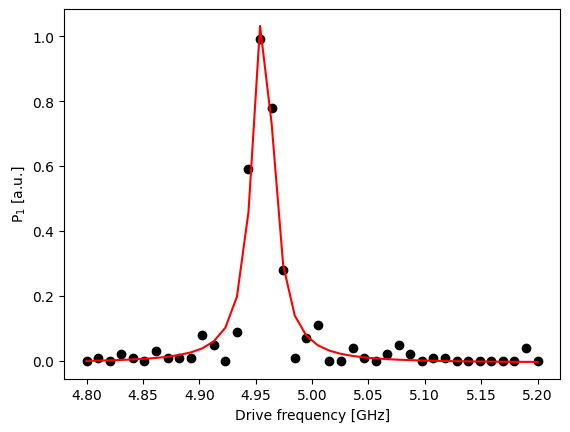

In [12]:
# b.1 fitting
#########################################
# Curve fitting
#########################################
fit_params, y_fit = fit_function(freq_vec/1e9,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.94, 0.01, -0.001] # initial parameters for curve_fit
                                )
rough_f = fit_params[1] * 1e9; 
print(f"Estimated qubit frequency: {rough_f/1e9:.4f} GHz")

#########################################
# Graphics
#########################################
plt.xlabel("Drive frequency [GHz]")
plt.ylabel("P$_1$ [a.u.]")
plt.scatter(freq_vec/1e9, sweep_values, color='black')
plt.plot(freq_vec/1e9, y_fit, color='red')
plt.show()

Pi Amplitude = 0.17506206419237813
Pi/2 Amplitude = 0.08753103209618907


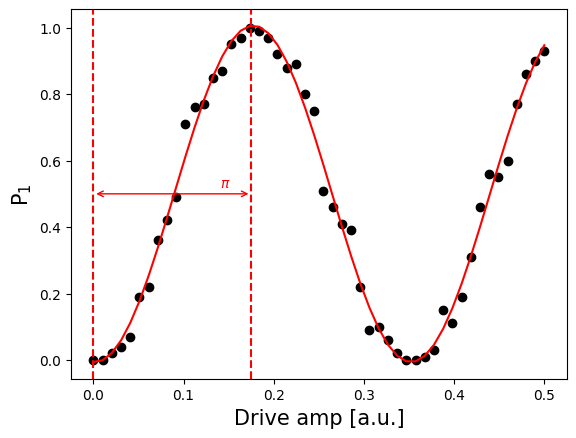

In [15]:
######################################### b. 1 Rabi oscillation
# Experiment parameters
#########################################
num_points          = 50;
duration            = 128; 
drive_amp_min       = 0;
drive_amp_max       = .5;
num_shots_per_point = 100;

#########################################
# Parametric schedule creation
#########################################
drive_amps  = np.linspace(drive_amp_min, drive_amp_max, num_points)
drive_amp   = Parameter('drive_amp')
with pulse.build(default_alignment='sequential') as rabi_sched:
    pulse.set_frequency(rough_f,pulse.DriveChannel(0)); 
    pulse.play(pulse.Constant(duration,
                                drive_amp,
                                name="Rabi Pulse"),
                                pulse.DriveChannel(0)); 
    pulse.acquire(1,0,pulse.MemorySlot(0)); 
rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

#########################################
# Backend simulation
#########################################
job = backend.run(rabi_schedules, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
rabi_results = job.result()

#########################################
# P1 computation
#########################################
rabi_values = []
for i in range(num_points):
    try:
        p1 = rabi_results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    rabi_values.append(p1/num_shots_per_point)

#########################################
# Curve fitting
#########################################
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.sin(2*np.pi*x/drive_period - phi) + B),
                                 [0.5, -0.5, 2, 0])
pi_amp = abs(fit_params[2] / 2)
print(f"Pi Amplitude = {pi_amp}")
print(f"Pi/2 Amplitude = {pi_amp/2}")

#########################################
# Graphics
#########################################
plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
plt.axvline(pi_amp, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.annotate("", xy=(0, 0.5), xytext=(pi_amp,0.5), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp * .8, 0.52), color='red')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("P$_1$", fontsize=15)
plt.show()

Ramsey frequency (natural + forced): 10.181 MHz
Ramsey frequency (natural): 0.181 MHz
Updated drive frequency: 4.956246 GHz
Detuning: 15.613 kHz


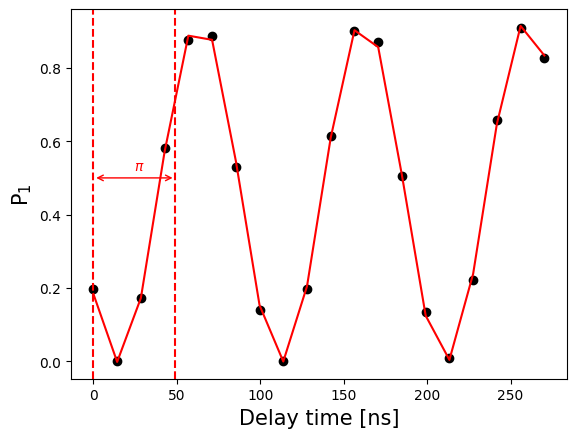

In [16]:
# b.2 Ramsey exp

#########################################
# X-90 pulse creation
#########################################
with pulse.build(default_alignment='sequential') as x_pihalf:
    pulse.play(pulse.Constant(duration,pi_amp/2,name="$\pi/2$-Rabi Pulse"),pulse.DriveChannel(0)); 

#########################################
# X pulse creation
#########################################
with pulse.build(default_alignment='sequential') as x_pi:
    pulse.play(pulse.Constant(duration,pi_amp,name="$\pi$-Rabi Pulse"),pulse.DriveChannel(0)); 


#########################################
# Experiment parameters
#########################################
num_points          = 20;       # Number of delays to test
delay_dt            = 64;       # Delay increment between schedules [dt]
detune              = 10e6;     # Forced detuning [Hz]
num_shots_per_point = 1000; 

#########################################
# Parametric schedule construction
#########################################
delay = Parameter('delay')
with pulse.build(default_alignment='sequential') as rams_sched:
    pulse.set_frequency(rough_f+detune,pulse.DriveChannel(0)); 
    pulse.call(x_pihalf);
    pulse.delay(delay,pulse.DriveChannel(0)); 
    pulse.call(x_pihalf); 
    pulse.acquire(1,0,pulse.MemorySlot(0)); 
delay_vec       = np.linspace(0,(num_points-1),num_points)*delay_dt;
rams_schedules  = [rams_sched.assign_parameters({delay: a}, inplace=False) for a in delay_vec]

#########################################
# Backend simulation
#########################################
job = backend.run(rams_schedules, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
results = job.result()

#########################################
# P1 computation
#########################################
rams_values = []
for i in range(num_points):
    try:
        p1 = results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    rams_values.append(p1/num_shots_per_point)

#########################################
# Curve fitting
#########################################
delay_times         = delay_vec*dt; 
fit_params, y_fit   = fit_function(delay_times,
                                   rams_values,
                                   lambda x, A, B, delay_period, phi: (A*np.sin(2*np.pi*x/delay_period - phi) + B),
                                   [0.5, -0.5, 100e-9, 0])
delay_period    = fit_params[2];
ramsey_f        = 1/delay_period; 
qubit_f         = rough_f - (ramsey_f - detune); 
print(f"Ramsey frequency (natural + forced): {ramsey_f/1e6:.3f} MHz")
print(f"Ramsey frequency (natural): {(ramsey_f-detune)/1e6:.3f} MHz")
print(f"Updated drive frequency: {(-ramsey_f+rough_f+detune)/1e9:.6f} GHz")
print(f"Detuning: {(qubit_f-omega/2/np.pi)/1e3:.3f} kHz")

#########################################
# Graphics
#########################################
plt.scatter(delay_times/1e-9, rams_values, color='black')
plt.plot(delay_times/1e-9, y_fit, color='red')
plt.axvline((delay_times[0] + delay_period/2)/1e-9, color='red', linestyle='--')
plt.axvline((delay_times[0])/1e-9, color='red', linestyle='--')
plt.annotate("", xy=(delay_times[0]/1e-9, 0.5), xytext=((delay_times[0] + delay_period/2)/1e-9,0.5), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=((delay_times[0] + delay_period/4)/1e-9, 0.52), color='red')
plt.xlabel("Delay time [ns]", fontsize=15)
plt.ylabel("P$_1$", fontsize=15)
plt.show()

Pi Amplitude = 0.17681314306346183
Pi/2 Amplitude = 0.08840657153173091


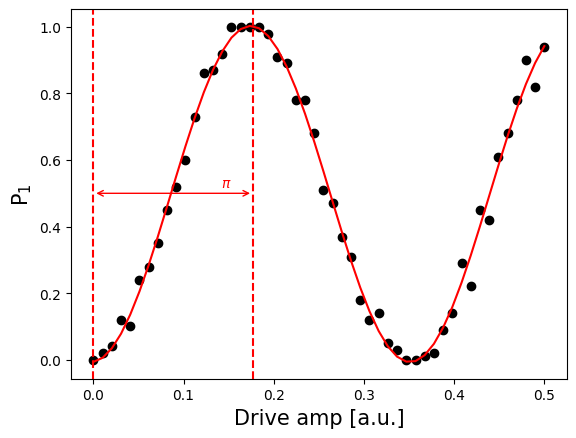

In [18]:
# b.3 updated Rabi pulse
#########################################
# Experiment parameters
#########################################
num_points          = 50
duration            = 128; 
drive_amp_min       = 0
drive_amp_max       = .5
num_shots_per_point = 100

#########################################
# Parametric schedule creation
#########################################
drive_amp = Parameter('drive_amp')
with pulse.build() as rabi_sched:
    with pulse.align_sequential():
        pulse.set_frequency(qubit_f,pulse.DriveChannel(0)); 
        pulse.play(pulse.Constant(duration,
                                  drive_amp,
                                  name="Rabi Pulse"),
                   pulse.DriveChannel(0)); 
        pulse.acquire(1,0,pulse.MemorySlot(0)); 
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_points)
rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

#########################################
# Backend simulation
#########################################
job = backend.run(rabi_schedules, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
rabi_results = job.result()

#########################################
# P1 computation
#########################################
rabi_values = []
for i in range(num_points):
    try:
        p1 = rabi_results.get_counts(i)['1'];
    except KeyError:
        p1 = 0; 
    rabi_values.append(p1/num_shots_per_point)

#########################################
# Curve fitting
#########################################
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.sin(2*np.pi*x/drive_period - phi) + B),
                                 [0.5, -0.5, 2, 0])
pi_amp = abs(fit_params[2] / 2)
print(f"Pi Amplitude = {pi_amp}")
print(f"Pi/2 Amplitude = {pi_amp/2}")

#########################################
# Graphics
#########################################
plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
plt.axvline(pi_amp, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.annotate("", xy=(0, 0.5), xytext=(pi_amp,0.5), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp * .8, 0.52), color='red')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("P$_1$", fontsize=15)
plt.show()

In [19]:
#########################################
# X-90 pulse creation
#########################################
with pulse.build(default_alignment='sequential') as x_pihalf:
    pulse.play(pulse.Constant(duration,pi_amp/2,name="$\pi/2$-Rabi Pulse"),pulse.DriveChannel(0)); 

#########################################
# X pulse creation
#########################################
with pulse.build(default_alignment='sequential') as x_pi:
    pulse.play(pulse.Constant(duration,pi_amp,name="$\pi$-Rabi Pulse"),pulse.DriveChannel(0)); 